# Train a VGG model for Zeiss using Transfer Learning
#### Load the modified VGG trained on Hamamatsu slides
#### Freeze all the convolutional and maxpooling layers
#### Train the dense, dropout, batch normalization and softmax layers
#### Add channel swap function (not yet test)

In [1]:
import os
from random import seed, sample, shuffle
import numpy as np
import cv2
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.optimizers import SGD, Adam
from keras. callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 32
epochs = 120
amount = 25000
channel_swap = 0

In [3]:
path1 = 'E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_transfer_zeiss'
path = 'E:\\deeplearning\\Hepatocarcinomes\\data\\5x\\test_zeiss\\testset'

In [4]:
lpos_ = []
for root, dirs, files in os.walk(path+'\\nor' , topdown=True):
    for f in files:
        if f.endswith('.tif'):
            lpos_.append(root+'\\'+f)
seed(1)
lpos = sample(lpos_, amount)
lpos_train = lpos[0:int(amount*0.8)]
lpos_val = lpos[int(amount*0.8):amount]

In [5]:
lneg_ = []
for root, dirs, files in os.walk(path+'\\tum' , topdown=True):
    for f in files:
        if f.endswith('.tif'):
            lneg_.append(root+'\\'+f)
seed(1)
lneg = sample(lneg_, amount)
lneg_train = lneg[0:int(amount*0.8)]
lneg_val = lneg[int(amount*0.8):amount]

In [6]:
ltrain = lpos_train + lneg_train
lval = lpos_val + lneg_val
np.random.seed(1) 
np.random.shuffle(ltrain)
np.random.seed(1) 
np.random.shuffle(lval)

In [7]:
#show effect of channel swap
if channel_swap:
    img = cv2.imread('E:\\deeplearning\\Hepatocarcinomes\\data\\5x\\test_biopsy\\P591234_1\\512_image_label_tissu\\img_00000.tif')
    img2 = np.empty(shape=(512,512,3),dtype=np.uint8)
    r = [0,1,2]
    for i in range(9):
        shuffle(r)
        img2[:,:,0] = img[:,:,r[0]]
        img2[:,:,1] = img[:,:,r[1]]
        img2[:,:,2] = img[:,:,r[2]]
        plt.subplot(int('33'+str(i+1))),plt.imshow(img2,'gray'),plt.title(r)
plt.show()

In [8]:
img_train = np.ndarray((int(amount*1.6), 64, 64, 3))

if channel_swap:
    img2 = np.empty(shape=(64,64,3),dtype=np.uint8)
    r = [0,1,2]
    for i in range(int(9)):
        img = cv2.imread(ltrain[i], -1)/255
        shuffle(r)
        img_train[i, :, :, 0] = img[:,:,r[0]]
        img_train[i, :, :, 1] = img[:,:,r[1]]
        img_train[i, :, :, 2] = img[:,:,r[2]]
        if i<9:
            plt.subplot(int('33'+str(i+1))),plt.imshow((img_train[i, :, :, :]*255).astype(np.uint8),'gray')
else:
    for i in range(int(amount*1.6)):
        image = cv2.imread(ltrain[i], -1)
        img_train[i, :, :, :] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255 #opencv: BGR!!! 255!!!

In [9]:
img_val = np.ndarray((int(amount*0.4), 64, 64, 3))

if channel_swap:
    img2 = np.empty(shape=(64,64,3),dtype=np.uint8)
    r = [0,1,2]
    for i in range(int(9)):
        img = cv2.imread(lval[i], -1)/255
        shuffle(r)
        img_val[i, :, :, 0] = img[:,:,r[0]]
        img_val[i, :, :, 1] = img[:,:,r[1]]
        img_val[i, :, :, 2] = img[:,:,r[2]]
#         if i<9:
#             plt.subplot(int('33'+str(i+1))),plt.imshow((img_val[i, :, :, :]*255).astype(np.uint8),'gray')
else:
    for i in range(int(amount*0.4)):
        image = cv2.imread(lval[i], -1)
        img_val[i, :, :, :] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255

In [10]:
y_train = np.vstack((np.ones(int(amount*0.8), np.float32), np.zeros(int(amount*0.8), np.float32)))
y_val = np.vstack((np.ones(int(amount*0.2), np.float32), np.zeros(int(amount*0.2), np.float32)))

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

np.random.seed(1) 
np.random.shuffle(y_train)
np.random.seed(1) 
np.random.shuffle(y_val)

# for i in range(10):
#     print(y_train[i])
#     print(y_val[i])

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

In [11]:
model = load_model('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_dense_bn\\best_model')

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [13]:
for layer in model.layers[:-10]:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

In [14]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
csv_logger = CSVLogger(path1+'\\adam_32_lr4_training.csv', append=True)
model_checkpoint = ModelCheckpoint(path1+'\\adam_32_lr4_weights.{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_loss',verbose=1, save_best_only=True, period=15)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=15, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.005, cooldown=3, patience=8, verbose=1)
results = model.fit(img_train, y_train, batch_size, epochs=100, verbose=1, callbacks=[csv_logger, model_checkpoint, early_stop, reduce_lr], validation_data=(img_val, y_val))
csv_logger.csv_file.close()

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 97s 2ms/step - loss: 0.4194 - acc: 0.8254 - val_loss: 0.3832 - val_acc: 0.8399
Epoch 2/100
40000/40000 [==============================] - 91s 2ms/step - loss: 0.3847 - acc: 0.8407 - val_loss: 0.5491 - val_acc: 0.7459
Epoch 3/100
40000/40000 [==============================] - 91s 2ms/step - loss: 0.3698 - acc: 0.8477 - val_loss: 0.4232 - val_acc: 0.8229
Epoch 4/100
40000/40000 [==============================] - 92s 2ms/step - loss: 0.3622 - acc: 0.8504 - val_loss: 0.5907 - val_acc: 0.7742
Epoch 5/100
40000/40000 [==============================] - 92s 2ms/step - loss: 0.3566 - acc: 0.8551 - val_loss: 0.4382 - val_acc: 0.8111
Epoch 6/100
40000/40000 [==============================] - 92s 2ms/step - loss: 0.3543 - acc: 0.8544 - val_loss: 0.3721 - val_acc: 0.8438
Epoch 7/100
40000/40000 [==============================] - 92s 2ms/step - loss: 0.3473 - acc: 0.8561 - val_loss: 0.3693 - 

In [16]:
model.save(path1 + '\\adam_32_lr4_best_model.hdf5')

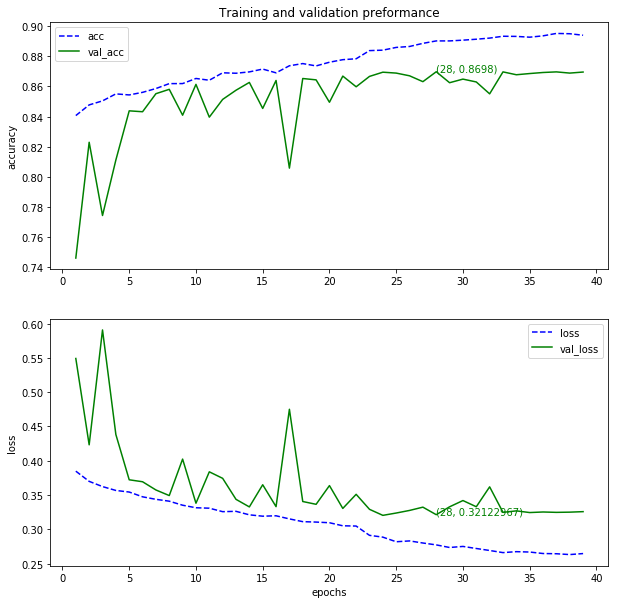

In [17]:
import csv
loss = []
val_loss = []
acc = []
val_acc = []

with open('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_transfer_zeiss\\adam_32_lr4_training.csv') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            loss.append(row['loss'])
            val_loss.append(row['val_loss'])
            acc.append(row['acc'])
            val_acc.append(row['val_acc'])
            line_count += 1
            
loss=np.array(loss, dtype=np.float32)#to use matplotlib, has to change list to np.array, otherwise the y axis will be autoscaled
val_loss=np.array(val_loss, dtype=np.float32)
acc=np.array(acc, dtype=np.float32)
val_acc=np.array(val_acc, dtype=np.float32)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('accuracy')
# plt.ylim((0, 5))

epochs=range(1, len(acc)+1)
plt.plot(epochs,acc,'b--',label='acc')
plt.plot(epochs, val_acc,'g',label='val_acc')
index0=np.where(val_acc==np.amax(val_acc))
for i in index0:
    plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
    
plt.title('Training and validation preformance')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 5))

epochs=range(1, len(loss)+1)
plt.plot(epochs,loss,'b--',label='loss')
plt.plot(epochs, val_loss,'g',label='val_loss')
for i in index0:
    plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
    
plt.legend()
plt.savefig(path1+'\\adam_32_lr4_training_validation_performance')
plt.show()

In [5]:
import csv
import numpy as np
from matplotlib import pyplot as plt
loss = []
val_loss = []
acc = []
val_acc = []

with open('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_no_drop\\logger.csv') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            loss.append(row['loss'])
            val_loss.append(row['val_loss'])
            acc.append(row['acc'])
            val_acc.append(row['val_acc'])
            line_count += 1
            
loss=np.array(loss, dtype=np.float32)#to use matplotlib, has to change list to np.array, otherwise the y axis will be autoscaled
val_loss=np.array(val_loss, dtype=np.float32)
acc=np.array(acc, dtype=np.float32)
val_acc=np.array(val_acc, dtype=np.float32)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('accuracy')
# plt.ylim((0, 5))

epochs=range(1, len(acc)+1)
plt.plot(epochs,acc,'b--',label='acc')
plt.plot(epochs, val_acc,'g',label='val_acc')
index0=np.where(val_acc==np.amax(val_acc))
for i in index0:
    plt.text(epochs[int(i)], val_acc[int(i)], str((epochs[int(i)], val_acc[int(i)])),color='g')
    
plt.title('Training and validation preformance')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim((0, 5))

epochs=range(1, len(loss)+1)
plt.plot(epochs,loss,'b--',label='loss')
plt.plot(epochs, val_loss,'g',label='val_loss')
for i in index0:
    plt.text(epochs[int(i)], val_loss[int(i)], str((epochs[int(i)], val_loss[int(i)])),color='g')
    
plt.legend()
plt.savefig('E:\\deeplearning\\Hepatocarcinomes\\models\\5x\\vgg16_no_drop\\'+'training_validation_performance')
plt.show()

<Figure size 1000x1000 with 2 Axes>